# LUMIN Introduction: Binary classification of signal & background
In this example we'll train a classifier to predict signal and background events using the data from the [HiggsML Kaggle challenge](https://www.kaggle.com/c/higgs-boson). The approach defined here follows that which I published in [Strong 2020](https://iopscience.iop.org/article/10.1088/2632-2153/ab983a) and will get us near the top of the leaderboard.

1. Data is imported from CSV format
1. Data is preprocessed
1. Initial feature selection is performed
1. An ensemble of densely-connected Swish-based networks is trained with a 1-cycle learning rate and beta-1 policy using a categorical entity embedding and train-time data augmentation
1. The resulting ensemble is evaluated on validation data using test-time data augmentation
1. The model is interpreted via feature importance, and embedding examination

We'll use the version of the data available from the [CERN OpenData portal](http://opendata.cern.ch/record/328?ln=en).

!mkdir data
!wget -O data/atlas-higgs-challenge-2014-v2.csv.gz http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip data/atlas-higgs-challenge-2014-v2.csv.gz

Next, we need to install lumin

!pip install lumin

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from pathlib import Path
PATH = Path('data/')

## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe.

In [3]:
data = pd.read_csv(PATH/'atlas-higgs-challenge-2014-v2.csv')

In [4]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


The dataset consists of a Higgs to di-tau signal, and several backgrounds ($Z\rightarrow\tau\tau$, $t\bar{t}$, and $W$ decay).

The particles in the events consist of:
- hadronic tau jet
- light lepton (electron or muon)
- Up to to jets (ordered by $p_t$), when these are not present, the default feature values are -999

Feature-wise we have:
- Low-level information: the ($p_t,\eta,\phi$) of the particles (`PRI_*`)
- High level features computed from the particles (`DER_`)

Our aim is to maximise the signal significance (Approximate Median Significance - AMS) by predicting for each event whether it is signal or background. The AMS is then computed on events predicted as being signal.

The data contains both the training and test sets, so we'll extract those out. Additionally, we'll remove the private dataset, so we only evaluate on the public one, like in the proper Kaggle competition.

In [5]:
data.drop(columns=['Weight'], inplace=True)
data['Label'] = data['Label'].map({'s':1, 'b':0})
data.rename(index=str, columns={"KaggleWeight": "gen_weight", 'PRI_met': 'PRI_met_pt', 'Label':'gen_target'}, inplace=True)

df = pd.DataFrame(data.loc[data.KaggleSet == 't'])
df.drop(columns=['KaggleSet'], inplace=True)
    
test = pd.DataFrame(data.loc[(data.KaggleSet == 'b')])
test.drop(columns=['KaggleSet'], inplace=True)

LUMIN includes a function for displaying weighted data, which we can use to plot features:

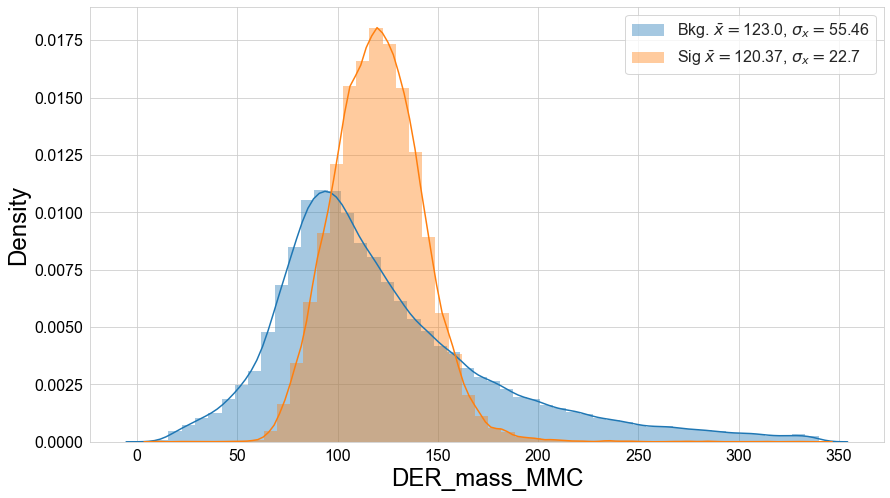

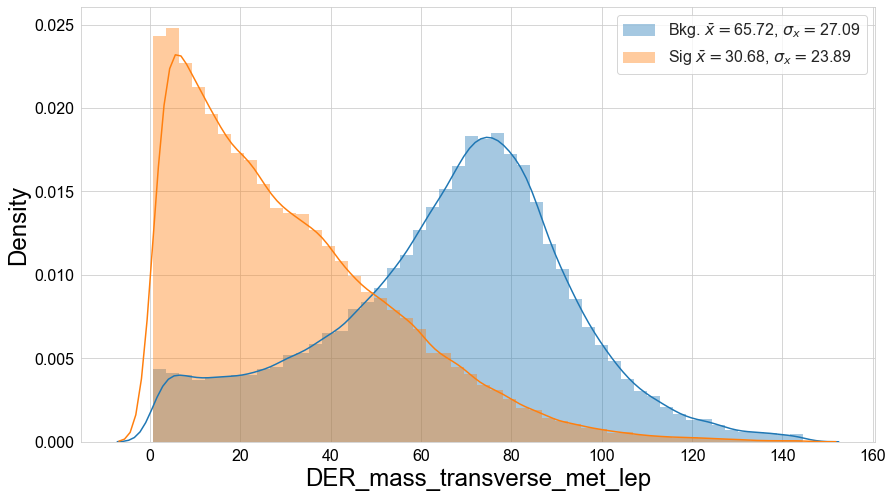

In [6]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(df, 'DER_mass_MMC', cuts=[(df.gen_target==0),(df.gen_target==1)], labels=['Bkg.','Sig'], wgt_name='gen_weight')
plot_feat(df, 'DER_mass_transverse_met_lep', cuts=[(df.gen_target==0),(df.gen_target==1)], labels=['Bkg.','Sig'], wgt_name='gen_weight')

### Preprocessing
Having imported the data, we now need to further process it into form suitable for training the classifier. We'll apply the following transformations:

- Convert the 3-momenta into Cartesian coordinates ($p_x,p_y,p_z$)
- Change the feature values for missing jets from -999 to NaN
- Standardise and normalise the input features

In [7]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])
proc_event(test, use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])

Converting to use Cartesian coordinates
Converting to use Cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use. Note that we will treat the number of jets in the event as a categorical variable, rather than a continuous one.

In [8]:
targ_feat = 'gen_target'
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['EventId']
wgt_feat = 'gen_weight'
cat_feats = ['PRI_jet_num']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['PRI_jet_num']
30 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [9]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[[targ_feat] + cat_feats].values)

In [10]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
df.columns[df.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz']

In [12]:
test.columns[test.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz']

We've got some NaNs in the data, however this is due to non-existent jets, float precision, and algorithm non-convergence. These will eventually get replaced with zeros.

#### Train-validation split 

In [13]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=42)

Having pulled out a stratified random subsample, we can check whether it really is representative of the training data and testing data by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [14]:
from lumin.utils.data import check_val_set
check_val_set(train_df[train_feats], val_df[train_feats], test[train_feats])

/home/giles/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)



AUC for train-validation discrimination = 0.5000151388707373
Top 10 most important features are:
   index               Feature  Importance
0      0            DER_sum_pt    0.010633
1      1            DER_pt_tot    0.010383
2      2            PRI_met_py    0.005129
3      3  DER_pt_ratio_lep_tau    0.004128
4      4         PRI_met_sumet    0.003878
5      5      DER_mass_jet_jet    0.003378
6      6          DER_mass_MMC    0.003378
7      7            PRI_lep_py    0.003252
8      8            PRI_lep_pz    0.002752
9      9  DER_deltaeta_jet_jet    0.002377

AUC for test-validation discrimination = 0.49942763244178984
Top 10 most important features are:
   index                      Feature  Importance
0      0           PRI_jet_leading_pz    0.003746
1      1                   PRI_tau_py    0.003596
2      2          DER_prodeta_jet_jet    0.001798
3      3           PRI_jet_leading_py    0.001648
4      4         DER_deltaeta_jet_jet    0.001049
5      5  DER_mass_transverse_m

Looks like there is no way to tell the validation set apart from either the training or testing sets

#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [15]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH/'input_pipe')

In [16]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])
test[cont_feats] = input_pipe.transform(test[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [17]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df, test)
cat_maps, cat_szs

(OrderedDict([('PRI_jet_num', {0: 0, 1: 1, 2: 2, 3: 3})]),
 OrderedDict([('PRI_jet_num', 4)]))

### Weight processing
The data contains weights which are important to consider as they indicate which events are the most important to consider and are necessary to correctly compute the AMS at the end. However the data also contains an imbalance between signal and background in terms of raw event numbers. We can correct for this imbalance by renormalising the weights such that the sum for signal and background are equal, however since we might also want to compute the AMS on the training data, we'll make a copy of the column first.

In [18]:
train_df['gen_orig_weight'] = train_df['gen_weight']
train_df.loc[train_df.gen_target == 0, 'gen_weight'] /= np.sum(train_df.loc[train_df.gen_target == 0, 'gen_weight'])
train_df.loc[train_df.gen_target == 1, 'gen_weight'] /= np.sum(train_df.loc[train_df.gen_target == 1, 'gen_weight'])

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

The fold file is the core data-structure used throughout LUMIN. It is stored on disc as an HDF5 file and contains many *folds* (subsamples of the full dataset). In the top level are several groups. The meta_data group stores various datasets containing information about the data, such as the names of features. The other top-level groups are the folds. These store subsamples of the full dataset and are designed to be read into memory individually, and provide several advantages, such as:

- Memory requirements are reduced
- Specific fold indices can be designated for training and others for validation, e.g. for k-fold cross-validation
- Some methods can compute averaged metrics over folds and produce uncertainties based on standard deviation
- Each fold group contains several datasets:
- Targets will be used to provide target data for training NNs
- Inputs contains the input data in the following
- Weights, if present, will be used to weight losses during training
- Matrix_inputs can be used to store 2D matrix, or higher-order (sparse) tensor data

Additional datasets can be added, too, e.g. extra features that are necessary for interpreting results. Named predictions can also be saved to the fold file e.g. during Model.predict. Datasets can also be compressed to reduce size and loading time.

In [19]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['gen_orig_weight'],
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 20000 events
Saving fold 1 with 20000 events
Saving fold 2 with 20000 events
Saving fold 3 with 20000 events
Saving fold 4 with 20000 events
Saving fold 5 with 20000 events
Saving fold 6 with 20000 events
Saving fold 7 with 20000 events
Saving fold 8 with 20000 events
Saving fold 9 with 20000 events


In [20]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 5000 events
Saving fold 1 with 5000 events
Saving fold 2 with 5000 events
Saving fold 3 with 5000 events
Saving fold 4 with 5000 events
Saving fold 5 with 5000 events
Saving fold 6 with 5000 events
Saving fold 7 with 5000 events
Saving fold 8 with 5000 events
Saving fold 9 with 5000 events


In [21]:
df2foldfile(df=test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['private'],
            savename=PATH/'test', targ_type='float32')

Saving fold 0 with 10000 events
private not found in file
Saving fold 1 with 10000 events
private not found in file
Saving fold 2 with 10000 events
private not found in file
Saving fold 3 with 10000 events
private not found in file
Saving fold 4 with 10000 events
private not found in file
Saving fold 5 with 10000 events
private not found in file
Saving fold 6 with 10000 events
private not found in file
Saving fold 7 with 10000 events
private not found in file
Saving fold 8 with 10000 events
private not found in file
Saving fold 9 with 10000 events
private not found in file


## Train classifier

Now we're ready to begin training the network-based classifier.

### Data augmentation
Normally we would access the data using a `FoldYielder` class, however for this case we will use the `HEPAugFoldYielder` class. This will automatically apply data augmentation to our inputs when a fold is loaded. These transformations involve flipping the event in the $z$ and $y$ axes, and rotating the event in the transverse plane. During training, the transformations are applied randomly, but during testing, each event is predicted once for every $z$ and $y$ configuration at a specified number of angular rotations. The set of predictions are then averaged. Here, we specify that when applying test-time augmentation, we should compute two different rotations.
Only the 3-momenta features are transformed, which are identified by the suffix of the feature name containing, e.g. `PRI_lep_px`, `PRI_lep_py`, `PRI_lep_pz`.

In [22]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder

train_fy = HEPAugFoldYielder(PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


During training, this will randomly rotate the event in phi, randomly flip it in the y-axis, and randomly flip it in the z-axis. Lets view a few possible examples of the same event.

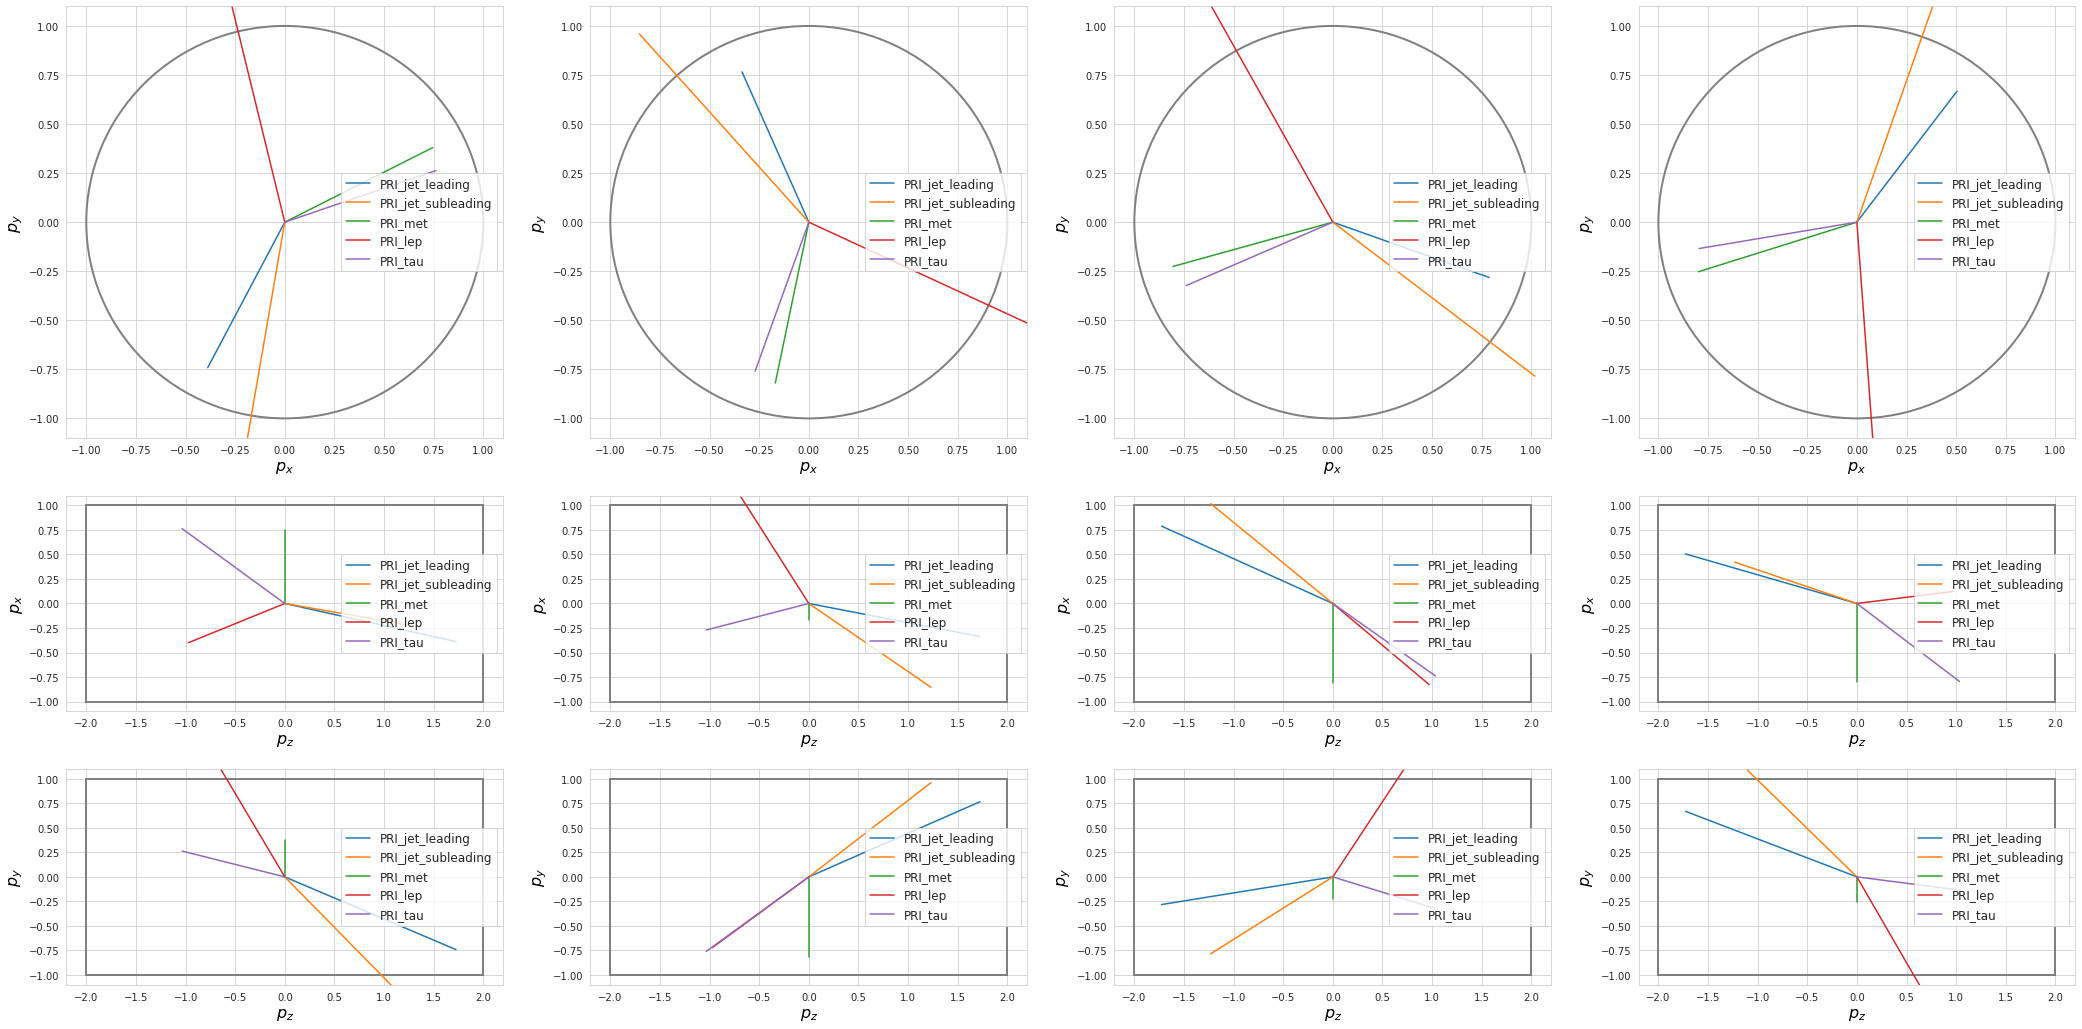

In [23]:
from lumin.plotting.data_viewing import compare_events

idx=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[idx:idx+1] for i in range(4)])

During testing it will provide versions of each possible combination of flips for 2 set rotations.

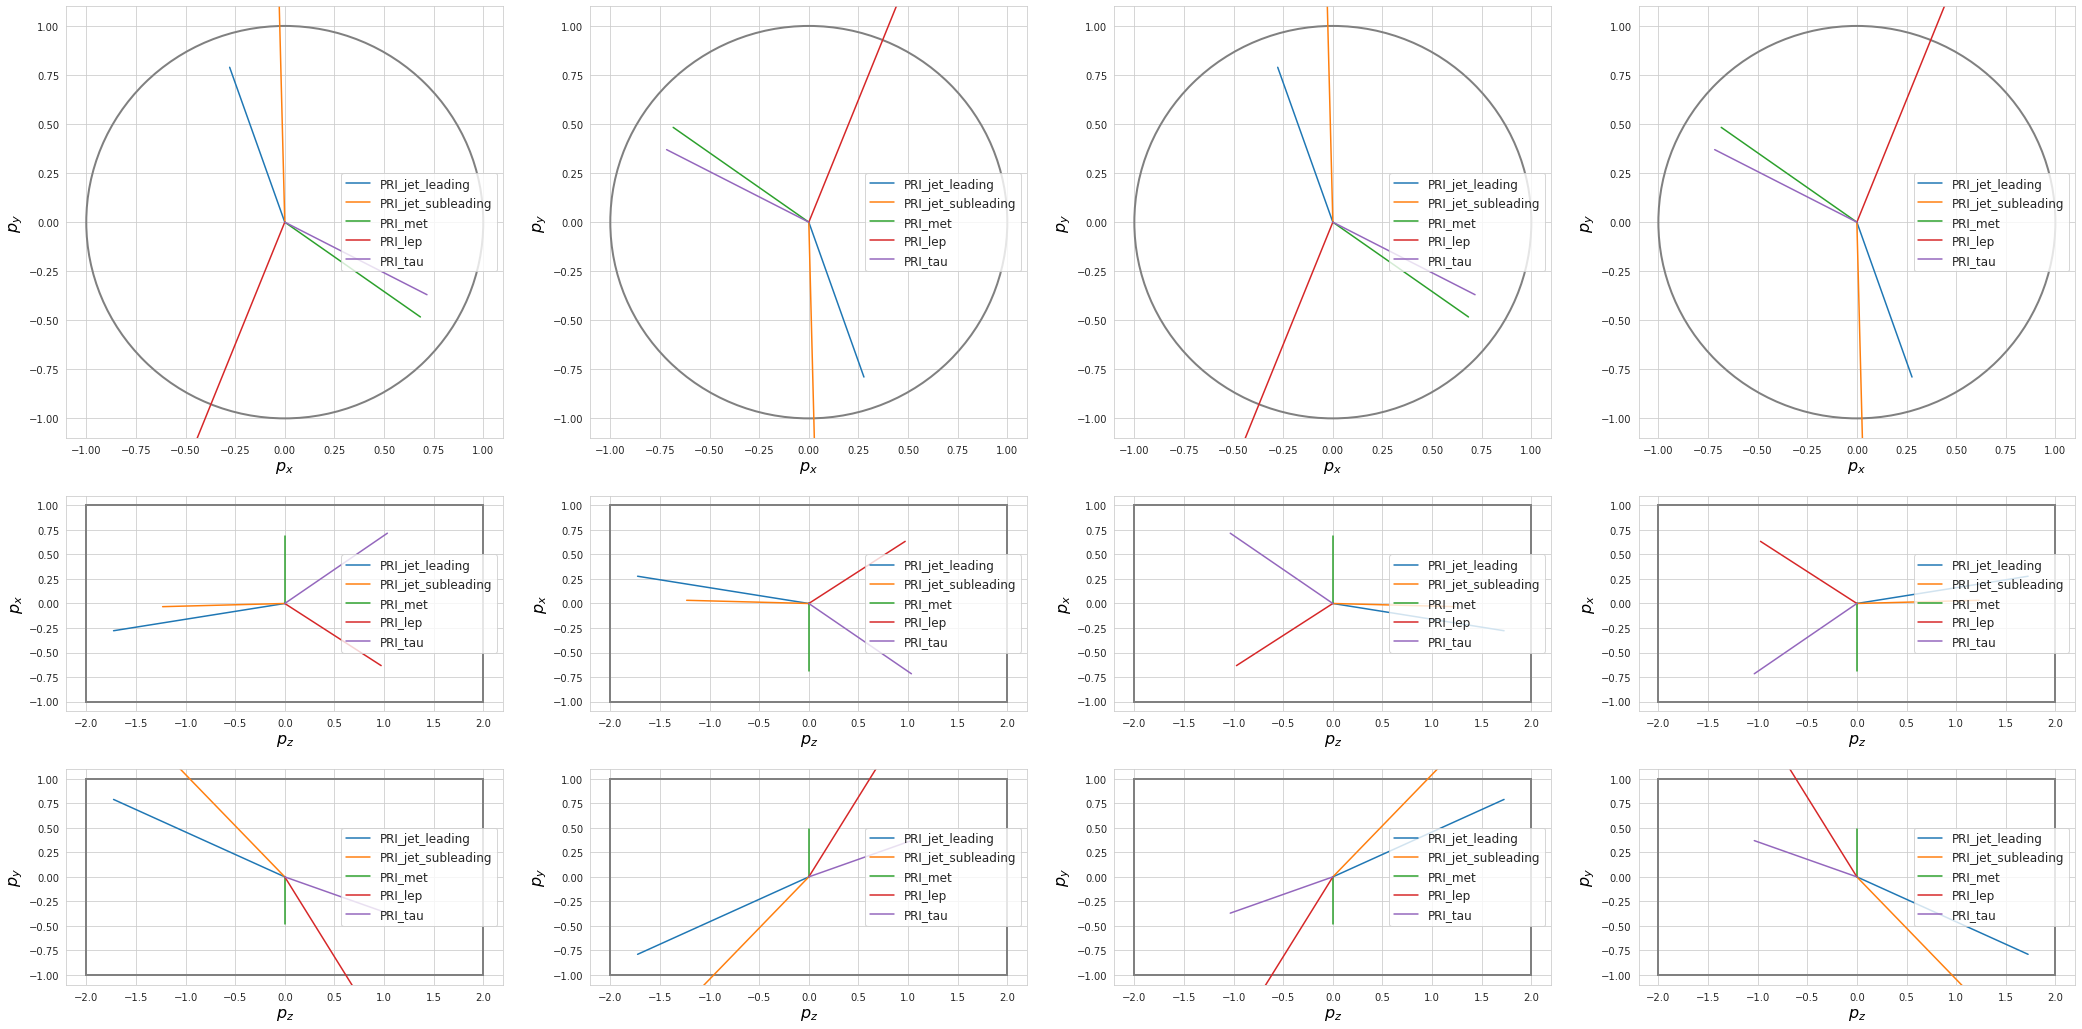

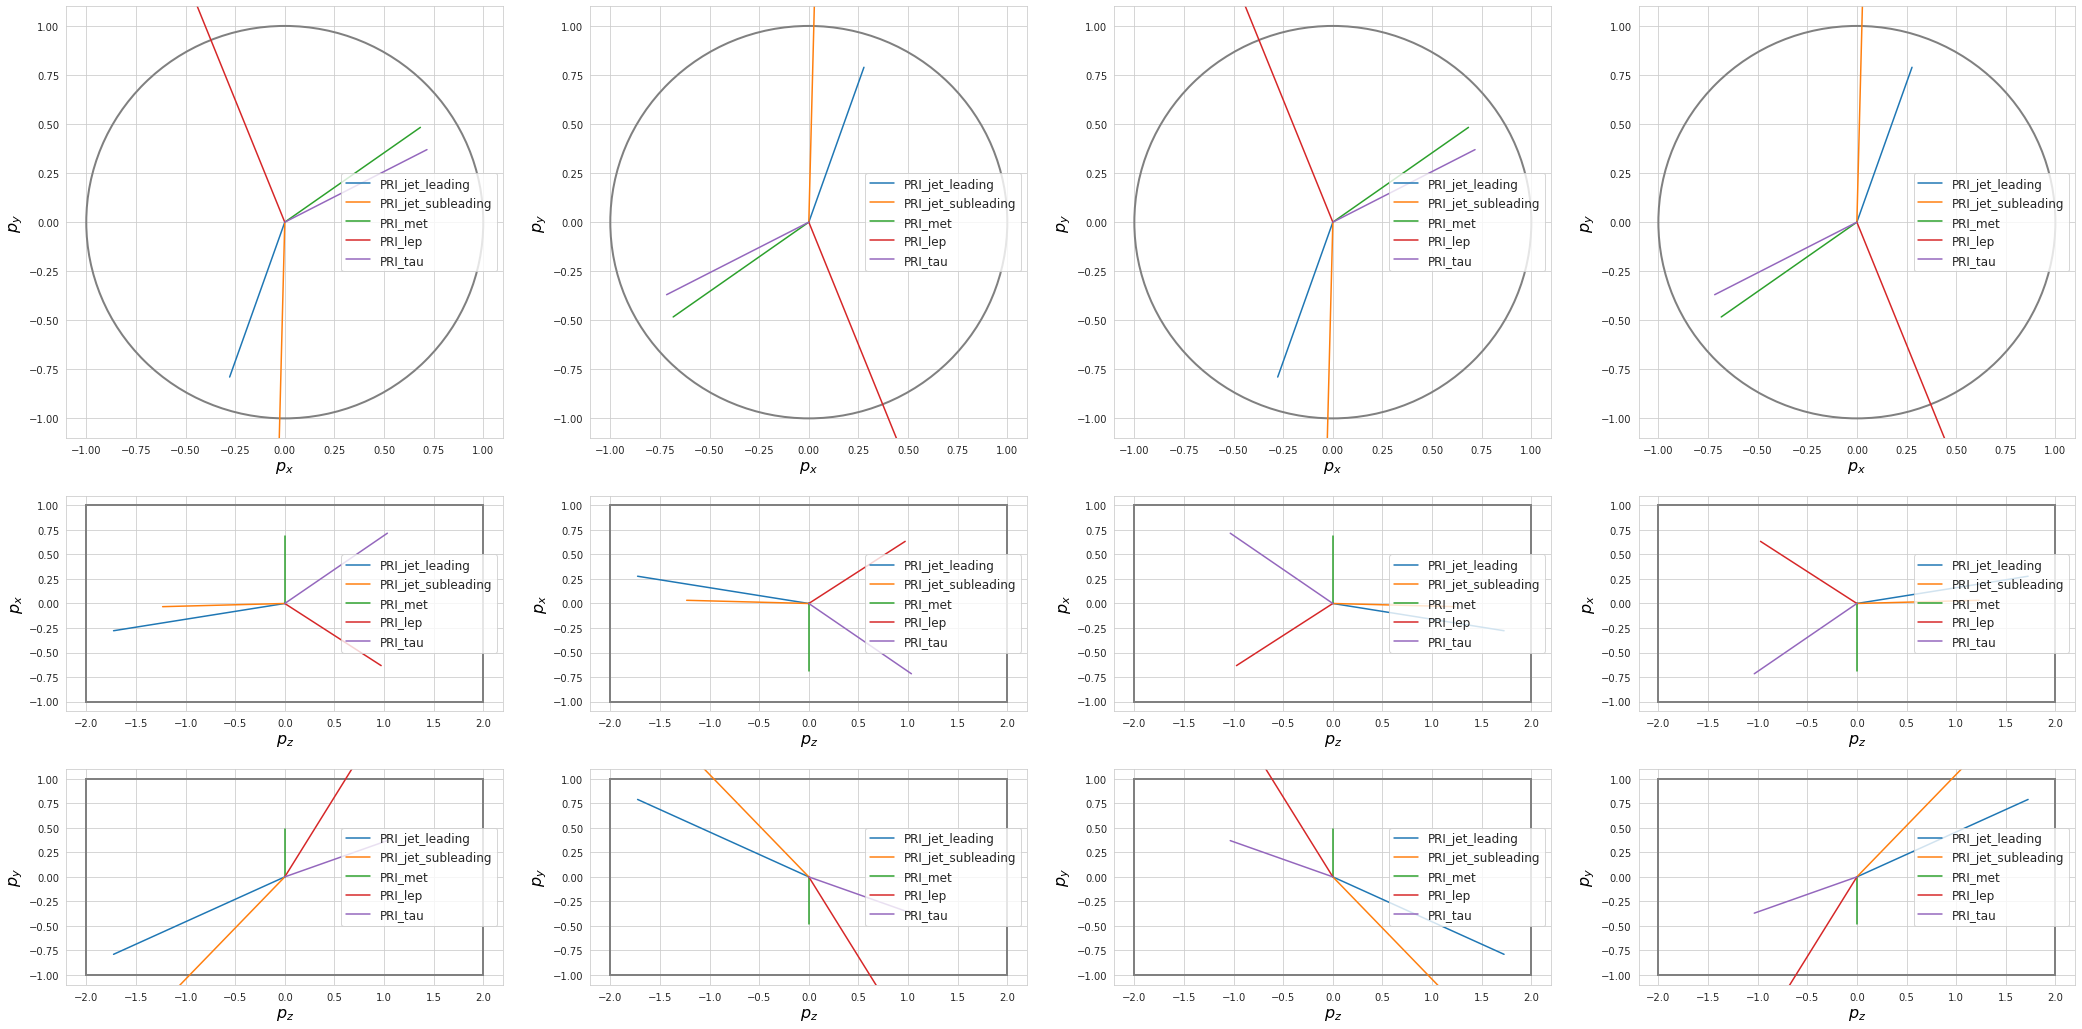

In [24]:
for aug_range in [range(4), range(4,8)]:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[idx:idx+1] for i in aug_range])

### ModelBuilder
In LUMIN, rather than building a model and training it, we tend to define *how* a model should be built and *how* it should be trained, and then tell a function how many models we would like to train. This means that training an ensemble of models is no more difficult than training a single model.

The `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.

The network consists of three parts:
- A head, which takes the inputs to the network;
- a body, which contains the majority of the hidden layers;
- and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified

Each of these have default classes which are suitable for most cases, however users can replace them if they wish, or provide different arguments to them.

In our case, the head-module will just apply an embedding matrix to the categorical features ([entity embeddings](https://arxiv.org/abs/1604.06737)), the output is concatenated with the continuous features and passed to the network body. More advanced heads could be, e.g. CNNs, RNNs, and GNNs.

The default body is a number of fully-connected hidden layers. We can specify the number and widths via arguments. For this case we will configure the body to be *densely connected*, meaning the the output of each layer is concatenated with the input to the layer, so no information is ever lost. For this it useful to use many thin layers, rather than a few wider layers.

The default tail scales down the hidden state to match the required number of outputs. The output activation function depends on the *objective* of the model. By using a "classification" objective, the output will have a sigmoid output (other objectives are 'labelclass*', 'multiclass', and 'regression'). The objective also defines the loss function used (unless we explicitly provide a loss function). Here we ant binary cross entropy, which is the default for a classification objective.

In [25]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder

bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':32, 'dense':True, 'depth':6}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Swish

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `lr_find`, runs several trainings using different folds of the data and then plots the mean and standard deviation of the loss.

LR finder took 36.597s 


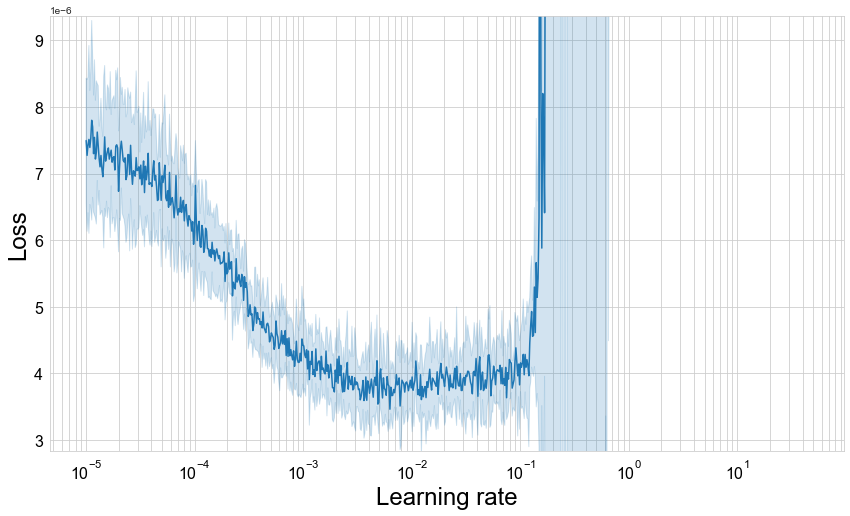

In [26]:
from lumin.optimisation.hyper_param import lr_find

lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e1])

Looks like somewhere around 1e-3 should be good, however we will be using a training schedule that is specifically designed to handle higher learning rates by reducing the momentum of the optimiser, so we'll bumb it up slightly to 1e-2.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll train an ensemble of 3 models trained using [the 1-cycle policy](https://arxiv.org/abs/1803.09820), with cosine interpolation. This initially starts at a low LR and high momentum, quickly ramps up to a high LR and low momentum, and then gradually anneals back to a lower LR and higher momentum. In practice this provides almost a linear loss decrease throught the main bulk of training. Note that the two numbers in the `lengths` parameter for the `OneCycle` class are the number of epochs in the first part of the cycle and the second part, respectively. Early stopping happens automatically after the cycle ends.

We'll also add an evaluation metric to compute the AMS on the validation folds. Note that we tell the AMS calculation to load the original weights, and tell it the total number of events in the sample. This allows the weights to be rescaled to account for the fact that the AMS will be calculated only on the validation folds, which are much smaller than the full training sample. `br=10` is a factor included in the HiggsML competition.

However unlike in other examples where we could confidently select models according to the metric computed on the validation data, the AMS really needs to computed on a large sample to be accurate, otherwise it is subject to statistical fluctuations. I.e. we want to ensure that early stopping and save best are computed using the loss but we still want to compute the AMS. Do do this, we can set `main_metric` to `False`.

In [27]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import AMS
from functools import partial

n_models = 3
patience = None
n_epochs = 15

cb_partials = [partial(OneCycle, lengths=[5, 10], lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = [partial(AMS, n_total=250000, br=10, wgt_name='gen_orig_weight', main_metric=False)]

`train_models` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of epochs have elapsed with out an improvement of the validation loss. The best performing model is automatically saved.

Training model 1 / 3, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


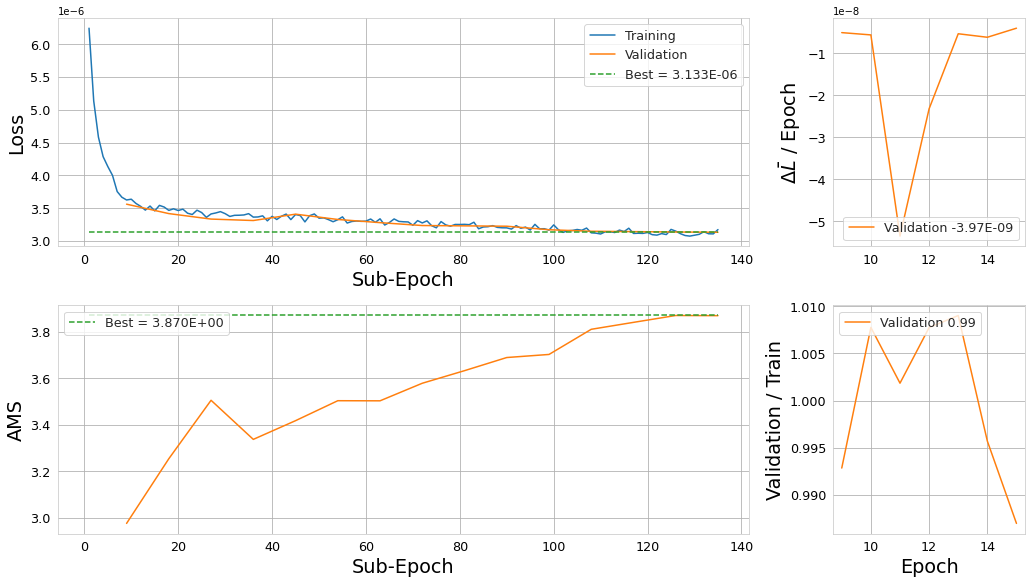

Loading best model with metric value 3.133E-06
Model took 79.712s

Scores are: {'loss': 3.1326612770499196e-06, 'AMS': 3.869608708990637}
Training model 2 / 3, Valid Index = 1, Train indices= [0, 2, 3, 4, 5, 6, 7, 8, 9]


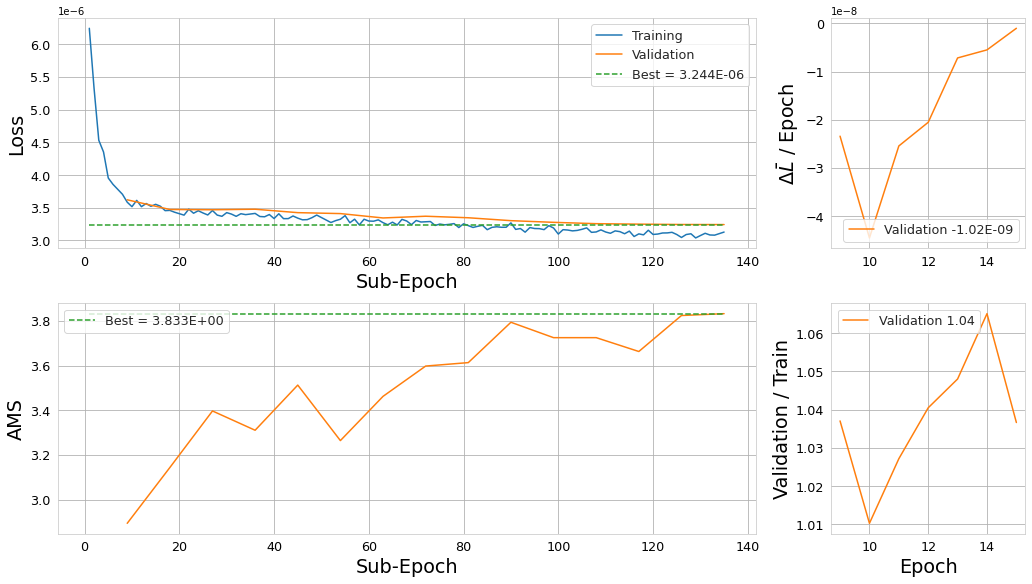

Loading best model with metric value 3.244E-06
Model took 84.049s

Scores are: {'loss': 3.243561650378979e-06, 'AMS': 3.8328646135063815}
Training model 3 / 3, Valid Index = 2, Train indices= [0, 1, 3, 4, 5, 6, 7, 8, 9]


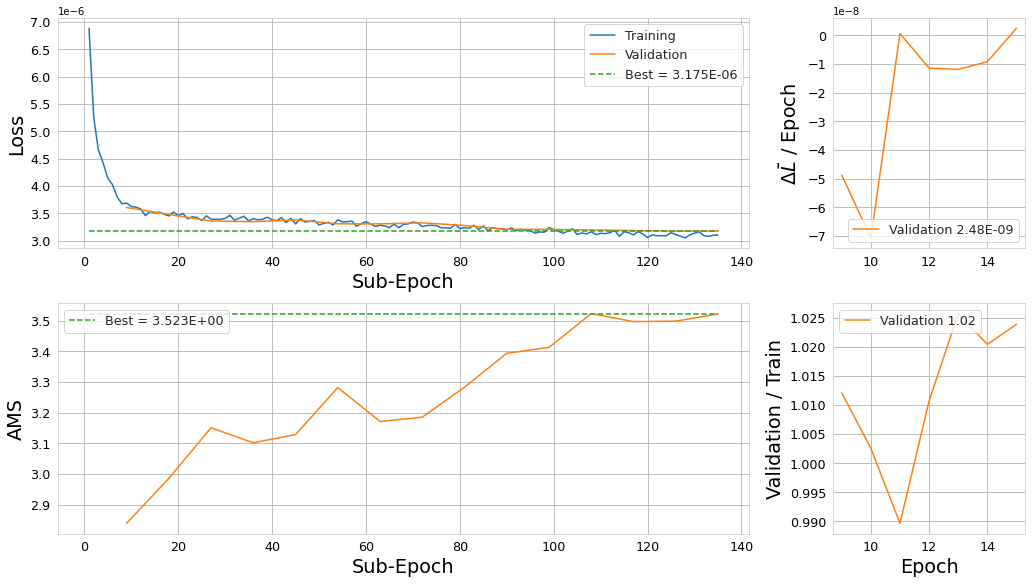

Loading best model with metric value 3.175E-06
Model took 77.822s

Scores are: {'loss': 3.1754454994370462e-06, 'AMS': 3.4987119183116135}

______________________________________
Training finished
Cross-validation took 241.781s 


<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

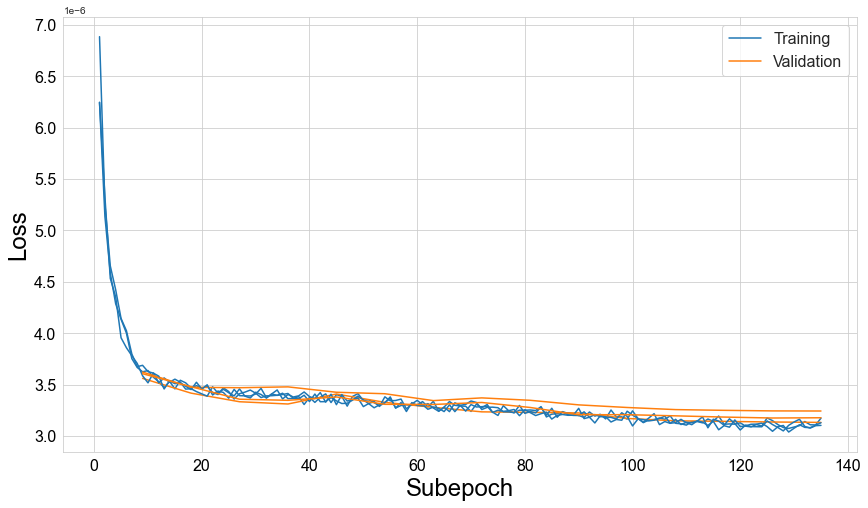

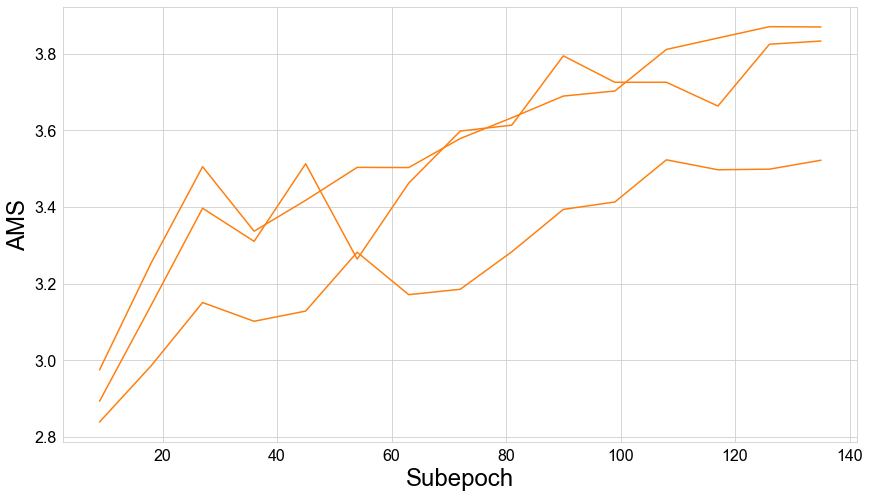

Mean loss = 3.18e-06±3e-08
Mean AMS = 3.73±0.1
______________________________________



In [28]:
from lumin.nn.training.train import train_models

results, _, _ = train_models(train_fy,  # Training data
                             n_models,  # Number of models to train
                             model_builder=model_builder,  # How to build models, losses, and optimisers
                             bs=bs,  # Batch size
                             cb_partials=cb_partials,  # List of uninitialised callbacks
                             metric_partials=metric_partials,  # Pass our evaluation metrics
                             n_epochs=n_epochs,  # Maximum number of epochs to train
                             patience=patience)  # If not None, stop training if validation loss doesn't improve after set number of cycles (automatic save best)

## Ensemble loading
We can now build an ensemble from the trained models, however rather than simply treating them all equally, we can weight them according to some metric (e.g. AMS, reciprocal of loss).

In [29]:
from lumin.nn.ensemble.ensemble import Ensemble

ensemble = Ensemble.from_results(results, n_models, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 0 with loss = 3.1326612770499196e-06
Model 1 is 2 with loss = 3.1754454994370462e-06
Model 2 is 1 with loss = 3.243561650378979e-06


The default location is likely to be overwritten, so we can save it to a more permanent location.

A saved `Ensemble` can be loaded via either:
- `e = Ensemble(); e.load(name)`, or
- `e = Ensemble.from_save(name)`

In [30]:
name = 'weights/Binary_Classification'
ensemble.save(name, feats=train_fy.cont_feats+train_fy.cat_feats, overwrite=True)

## Validation performance
Now we can test how well our ensemble performs on our validation set. Note that we supply the same input pipe that we used to process the training data.

In [31]:
from lumin.nn.data.fold_yielder import FoldYielder

val_fy = HEPAugFoldYielder(PATH/'val.hdf5', rot_mult=2, input_pipe='data/input_pipe.pkl')

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [32]:
ensemble.predict(val_fy)

In [33]:
val_df = val_fy.get_df(); val_df.head()

50000 datapoints loaded


,gen_target,gen_weight,pred
0,0.0,4.626144,0.474369
1,1.0,0.018636,0.809183
2,0.0,1.844780,0.004355
3,0.0,4.328671,0.018710
4,1.0,0.001503,0.870345


We can plot the prediction distribution using:

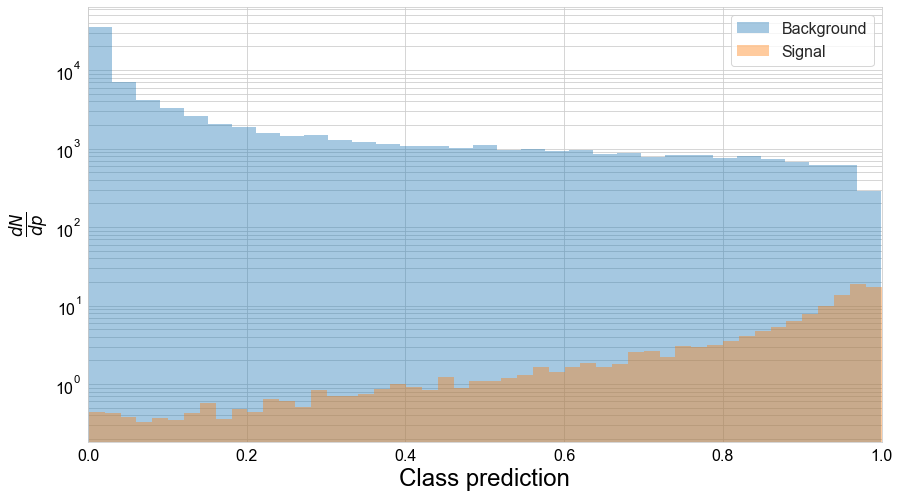

In [34]:
from lumin.plotting.results import plot_binary_class_pred
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

In the HiggsML challenge, prediction on the test set requires specifying whether each event is signal or background, meaning we need to apply a cut on our class prediction, above which to consider events as signal. We could simply scan across the events in the validation sample and see where the AMS is maximised, (note we apply a weight factor to account for the difference between our validation sample and the full training sample):

In [35]:
from lumin.evaluation.ams import ams_scan_slow

ams_scan_slow(val_df, br=10, wgt_factor=250000/50000, start_cut=0.9)

(3.810011269321213, 0.97112644)

So, we get a maximum AMS of 3.81 at a cut of 0.971. However, the maximum AMS is a tricky metric that can easily be affected by statistical fluctuations due to limited data. It is extremely likely that even though we are getting this result on unseen data, it will not generalise very well. Instead we want to try and capture the general trend of the AMS and place our cut in the approximate region of high performance, rather than picking exactly where the AMS happened to maximise on our data. I've experimented with numerous approaches (bootstrap resampling, cross-validation, KDEs, et cetera) and found that so far the most generalising method is to rank points by events by their AMS, and then take the mean prediction of the top 10% as the cut.

Mean cut at 0.9508205056190491 corresponds to AMS of 3.756850783739069
Maximum AMS for data is 3.810011269321213 at cut of 0.9711264371871948


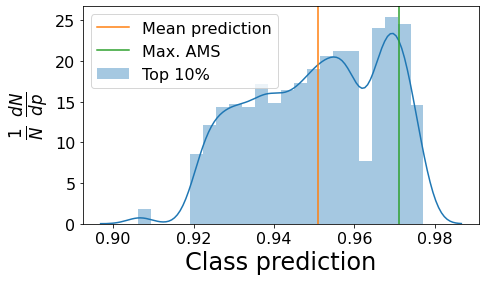

In [36]:
from lumin.optimisation.threshold import binary_class_cut_by_ams

cut, smooth_ams, max_ams = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

So, a drop in AMS to 3.76, when we take the mean cut, but hopefully this will offer better generalisation.

## Test scoring

With the OpenData version we have a labeled test set, so we can evaluate our score without submitting to Kaggle.

In [37]:
from lumin.evaluation.ams import calc_ams

def score_test_data(test_fy, cut, pred_name='pred'):
    data = pd.DataFrame()
    pred = test_fy.get_column(pred_name)
    
    data['pred'] = pred
    data['gen_weight'] = test_fy.get_column('weights')
    data['gen_target'] = test_fy.get_column('targets')

    accept = (data.pred >= cut)
    signal = (data.gen_target == 1)
    bkg = (data.gen_target == 0)

    public_ams = calc_ams(np.sum(data.loc[accept & signal, 'gen_weight']),
                          np.sum(data.loc[accept & bkg, 'gen_weight']))
numbers
    print(f"Public AMS: {public_ams}")    
    return public_ams

In [38]:
test_fy = HEPAugFoldYielder(PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [39]:
ensemble.predict(test_fy)

In [40]:
_ = score_test_data(test_fy, cut)

Public AMS: 3.7783827491212354


Nice, comparing to the private leaderboard (to account for overfitting of the cut) this would have placed us 4th out of 1,784 teams. Adding more models to the ensemble can further improve the score.

## Interpretation 
So we now have a model which is able to separate signal and background very well; one might very well be interested in what information the ensemble is using to get a handle on the data classes.

### Feature importance
In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

Top ten most important features:
                        Feature  Importance  Uncertainty
0                 DER_mass_vis    0.790558     0.030514
1               PRI_jet_all_pt    0.761747     0.033667
2           DER_deltar_tau_lep    0.660655     0.027632
3                   DER_sum_pt    0.648906     0.025128
4                   PRI_met_pt    0.534611     0.024161
5         DER_pt_ratio_lep_tau    0.302717     0.015476
6  DER_mass_transverse_met_lep    0.208523     0.014200
7                 DER_mass_MMC    0.200544     0.013149
8       DER_met_phi_centrality    0.104982     0.005713
9                     DER_pt_h    0.073529     0.006338


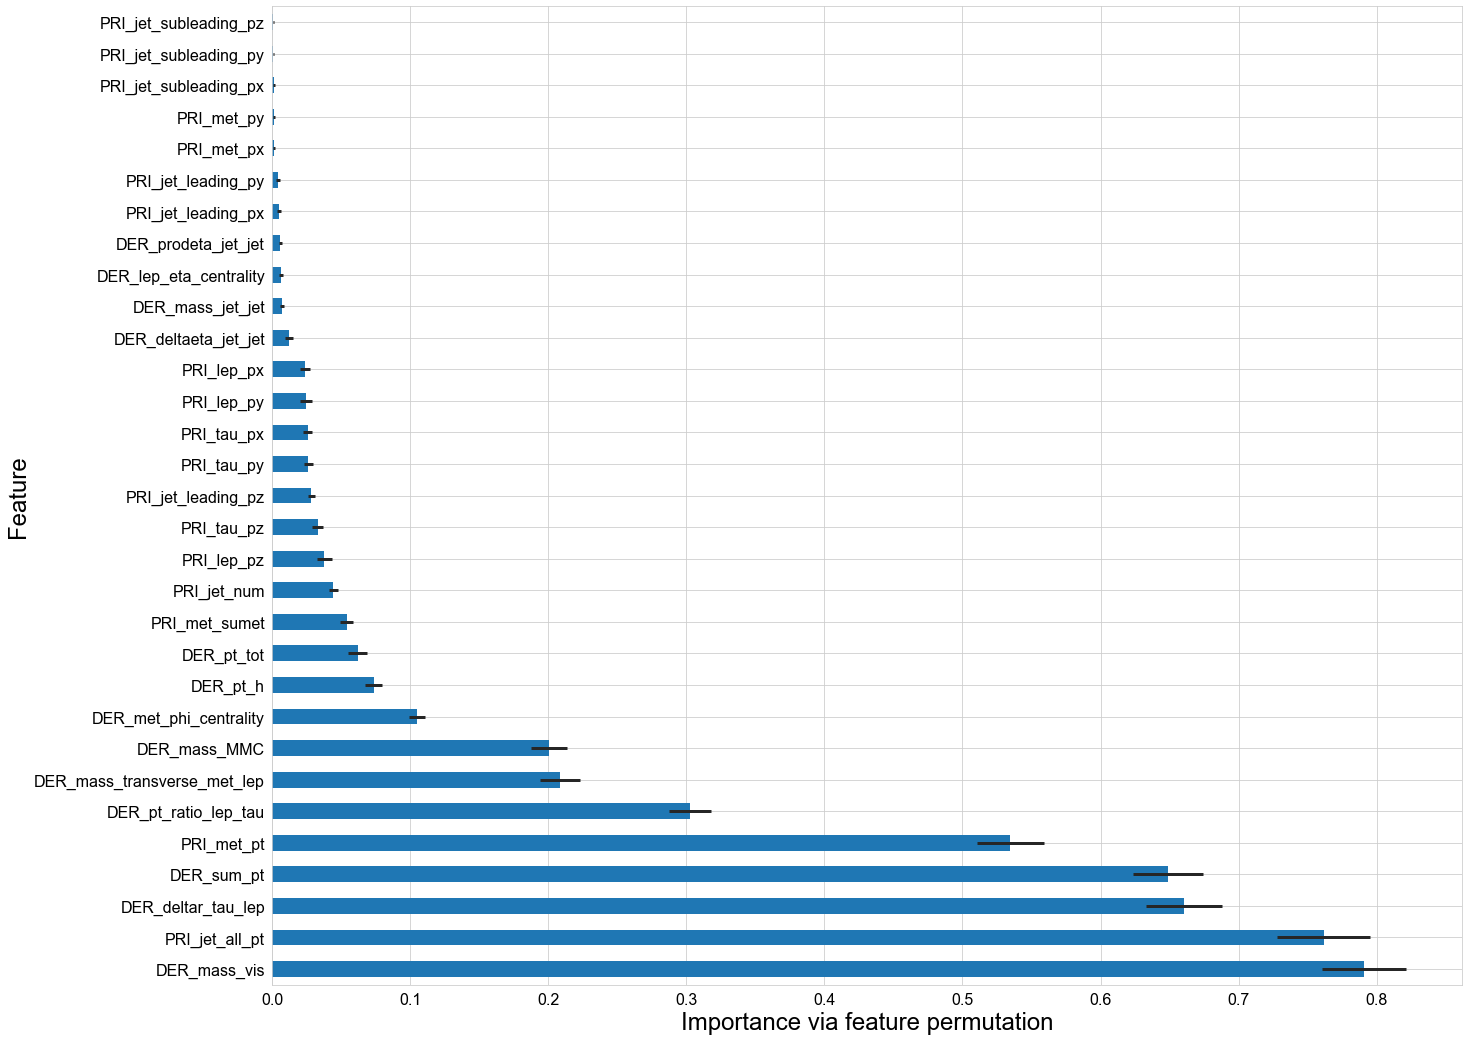

In [41]:
_ = ensemble.get_feat_importance(train_fy)

Interestingly, the ensemble mostly relies on high-level features, but there is a good spread of importance, rather than relying on a single feature.

Currently, we're measuring importance via changes in weighted binary cross-entropy. Instead we can get the effect on the AMS by passing an `eval_metric`, (this takes a while, though).

Top ten most important features:
                        Feature  Importance  Uncertainty
0                 DER_mass_vis    0.478175     0.031724
1                   DER_sum_pt    0.442168     0.035071
2  DER_mass_transverse_met_lep    0.344545     0.057406
3               PRI_jet_all_pt    0.295735     0.030666
4                 DER_mass_MMC    0.281671     0.043240
5         DER_pt_ratio_lep_tau    0.261554     0.074320
6           DER_deltar_tau_lep    0.230440     0.027443
7                   PRI_met_pt    0.219067     0.042478
8                  PRI_jet_num    0.139484     0.037966
9                     DER_pt_h    0.104569     0.035804


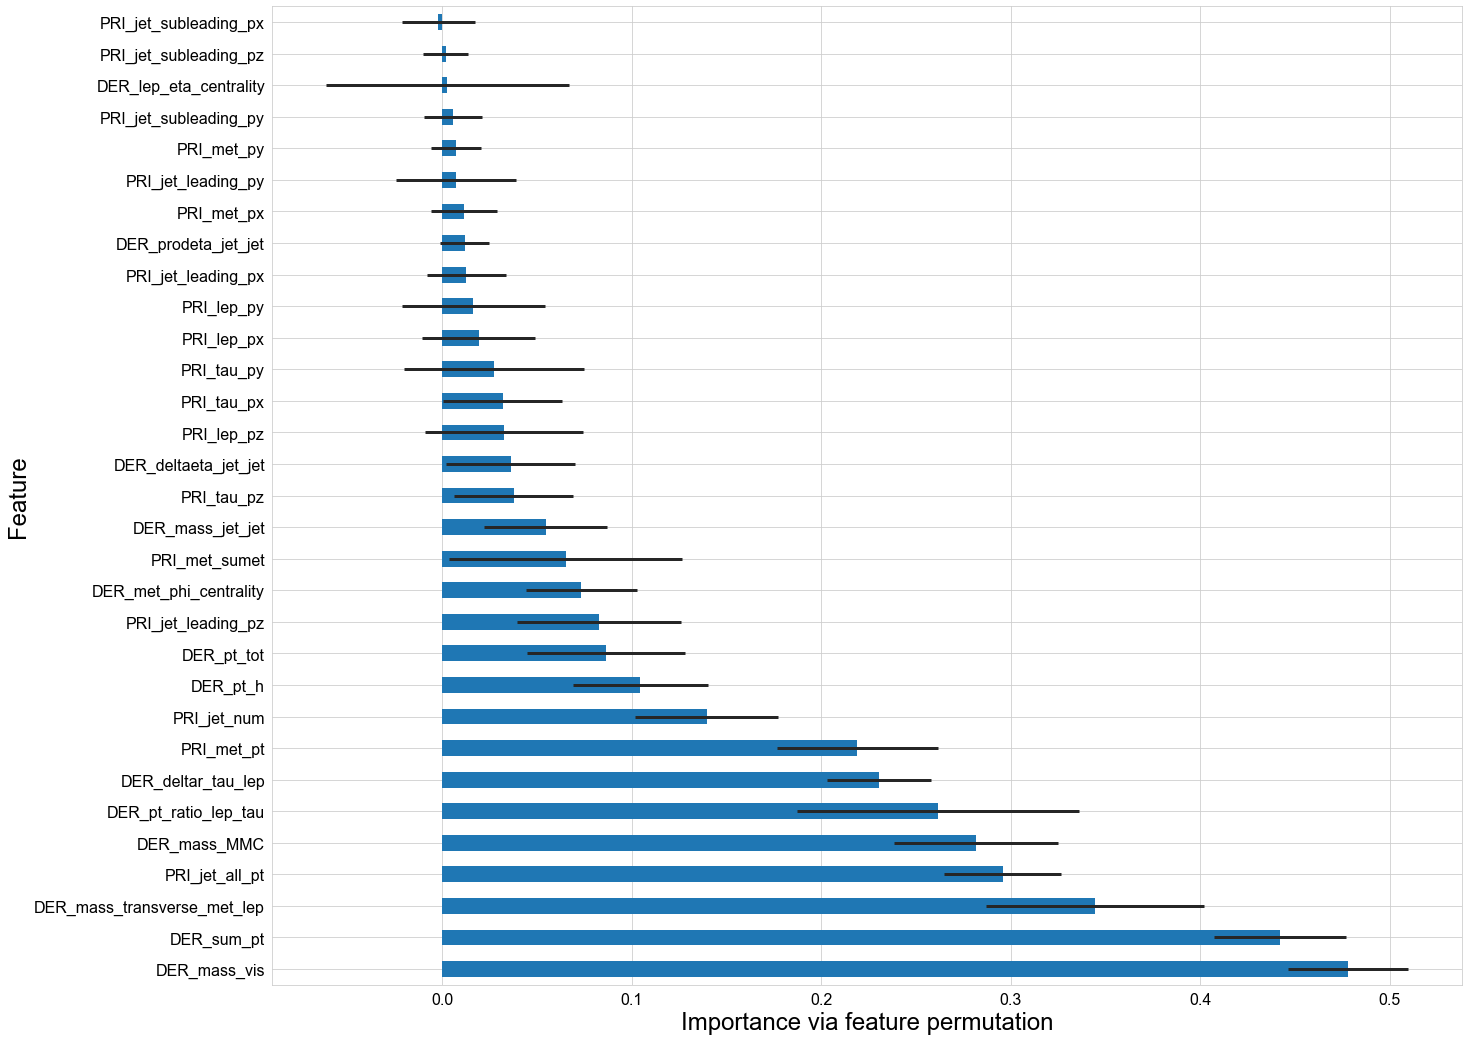

In [42]:
_ = ensemble.get_feat_importance(train_fy, eval_metric=AMS(n_total=250000, br=10, wgt_name='gen_orig_weight'))

The uncertainties have increased (the maximum AMS can fluctuate heavily).

### Embeddings
We treated the number of jets (`PRI_jet_num`) as a categorical feature, but rather than one-hot encode it, we used an [entity embedding](https://arxiv.org/abs/1604.06737) matrix to learn a more optimal representation. We can take a look at this matrix and see what was learnt.

In [43]:
_, m = ensemble[0]

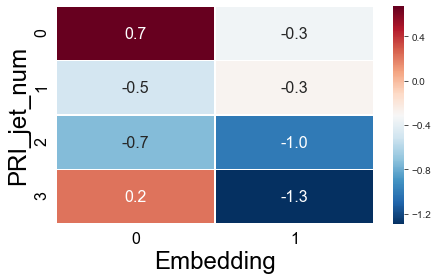

In [44]:
m.head.plot_embeds()

Each row seems to be unique, indicating the model was able to successfully encode the information. During training, we started from a random initialisation of the embedding matrix, however having learnt this representation, we could save it to use in similar problems as an initial set of weights. We can export the learned weight like this:

In [45]:
m.head.save_embeds(Path('weights'))

In [46]:
!ls weights

Binary_Classification_0.h5	   Binary_Classification_feats.pkl
Binary_Classification_1.h5	   Binary_Classification_results.pkl
Binary_Classification_2.h5	   Binary_Classification_weights.pkl
Binary_Classification_builder.pkl  PRI_jet_num.h5
